In [12]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define symbolic variables
x, y = sp.symbols('x y')

# Define the function
f = sp.sin(x) * sp.cos(y)

# Compute the gradient vector
gradient = [sp.diff(f, var) for var in (x, y)]

# Compute the Hessian matrix
hessian = sp.hessian(f, (x, y))

# Display the gradient and Hessian
print("Gradient vector:", gradient)
print("Hessian matrix:")
sp.pprint(hessian)

# Evaluate the function, gradient, and Hessian at a specific point (1, 0.2)
eval_point = {x: 1, y: 0.2}
function_value = f.evalf(subs=eval_point)
grad_value = [grad.evalf(subs=eval_point) for grad in gradient]
hessian_value = hessian.evalf(subs=eval_point)

print("\nFunction value at (1, 0.2):", function_value)
print("Gradient at (1, 0.2):", grad_value)
print("Hessian at (1, 0.2):")
sp.pprint(hessian_value)

# Golden Section Search
def golden_section_search(f, a, b, tol=1e-5):
    """
    Perform Golden Section Search to find the minimum of a function f.

    Parameters:
        f: Callable function to minimize.
        a: Left bound of the search interval.
        b: Right bound of the search interval.
        tol: Tolerance for stopping criterion.

    Returns:
        alpha_opt: Optimal step size minimizing f.
    """
    phi = (1 + np.sqrt(5)) / 2  # Golden ratio
    inv_phi = 1 / phi

    # Initialize points
    c = b - (b - a) * inv_phi
    d = a + (b - a) * inv_phi

    while abs(b - a) > tol:
        if f(c) < f(d):
            b = d
        else:
            a = c

        # Recompute points
        c = b - (b - a) * inv_phi
        d = a + (b - a) * inv_phi

    alpha_opt = (a + b) / 2
    
    print("alpha_opt: ", alpha_opt)
    return alpha_opt

# Gradient Descent
def gradient_descent(func, grad, start, iterations):
    point = np.array(start, dtype=float)
    path = [point]

    for _ in range(iterations):
        f_alpha = lambda alpha: func.evalf(subs={x: point[0] - alpha * grad[0].evalf(subs={x: point[0], y: point[1]}),
                                                y: point[1] - alpha * grad[1].evalf(subs={x: point[0], y: point[1]})})
        alpha = golden_section_search(f_alpha, 0, 1)
        grad_eval = np.array([g.evalf(subs={x: point[0], y: point[1]}) for g in grad], dtype=float)
        point = np.clip(point - alpha * grad_eval, -2, 2)
        path.append(point)

    return path

# Gradient Descent with Momentum
def gradient_descent_momentum(func, grad, start, beta, iterations):
    point = np.array(start, dtype=float)
    velocity = np.array([0.0, 0.0])
    path = [point]

    for _ in range(iterations):
        f_alpha = lambda alpha: func.evalf(subs={x: point[0] + alpha * velocity[0] - alpha * grad[0].evalf(subs={x: point[0], y: point[1]}),
                                                y: point[1] + alpha * velocity[1] - alpha * grad[1].evalf(subs={x: point[0], y: point[1]})})
        alpha = golden_section_search(f_alpha, 0, 1)
        grad_eval = np.array([g.evalf(subs={x: point[0], y: point[1]}) for g in grad], dtype=float)
        velocity = beta * velocity + alpha * grad_eval
        point = np.clip(point - velocity, -2, 2)
        path.append(point)

    return path

# Newton's Method
def newtons_method(grad, hess, start, iterations):
    point = np.array(start, dtype=float)
    path = [point]
    for _ in range(iterations):
        grad_eval = np.array([g.evalf(subs={x: point[0], y: point[1]}) for g in grad], dtype=float)
        hess_eval = np.array(hess.evalf(subs={x: point[0], y: point[1]}), dtype=float)
        hess_inv = np.linalg.inv(hess_eval)
        point = np.clip(point - np.dot(hess_inv, grad_eval), -2, 2)
        path.append(point)

    return path
def conjugate_gradient_method(func, grad, start, iterations):
    point = np.array(start, dtype=float)
    path = [point]
    grad_eval = np.array([g.evalf(subs={x: point[0], y: point[1]}) for g in grad], dtype=float)
    direction = -grad_eval

    for _ in range(iterations):
        f_alpha = lambda alpha: func.evalf(subs={x: point[0] + alpha * direction[0], y: point[1] + alpha * direction[1]})
        alpha = golden_section_search(f_alpha, 0, 1)
        point = np.clip(point + alpha * direction, -2, 2)
        path.append(point)
        new_grad_eval = np.array([g.evalf(subs={x: point[0], y: point[1]}) for g in grad], dtype=float)
        beta = np.dot(new_grad_eval, new_grad_eval) / np.dot(grad_eval, grad_eval)
        direction = -new_grad_eval + beta * direction
        grad_eval = new_grad_eval

    return path

import numpy as np
import sympy as sp

def dfp_method(func, grad, start, iterations):
    # Define symbolic variables
    x, y = sp.symbols('x y')  # Add this line to define x and y explicitly

    point = np.array(start, dtype=float)
    path = [point]
    dim = len(start)
    H = np.eye(dim)  # Initialize Hessian approximation as identity matrix

    for _ in range(iterations):
        # Evaluate gradient at the current point
        grad_eval = np.array([g.evalf(subs={x: point[0], y: point[1]}) for g in grad], dtype=float)
        
        # Compute the direction using the Hessian approximation
        direction = -np.dot(H, grad_eval)
        
        f_alpha = lambda alpha: func.evalf(subs={x: point[0] + alpha * direction[0], y: point[1] + alpha * direction[1]})
        alpha = golden_section_search(f_alpha, 0, 1)

        new_point = np.clip(point + alpha * direction, -2, 2)
        path.append(new_point)

        # Update s and y for the DFP formula
        s = new_point - point
        new_grad_eval = np.array([g.evalf(subs={x: new_point[0], y: new_point[1]}) for g in grad], dtype=float)
        y_diff = new_grad_eval - grad_eval  # Renamed y to y_diff to avoid naming conflict

        # Update the Hessian approximation
        rho = 1.0 / np.dot(y_diff, s)
        H = (np.eye(dim) - rho * np.outer(s, y_diff)) @ H @ (np.eye(dim) - rho * np.outer(y_diff, s)) + rho * np.outer(s, s)

        # Move to the new point
        point = new_point

    return path

# Parameters
start_point = [1, 0.2]
beta = 0.9
iterations = 2

# Run and visualize results
print("gradient_decent alpha: ")
path_gd = gradient_descent(f, gradient, start_point, iterations)
print("gradient_descent_momentum alpha: ")

path_momentum = gradient_descent_momentum(f, gradient, start_point, beta, iterations)

path_newton = newtons_method(gradient, hessian, start_point, iterations)
print("conjugate_gradient_method alpha: ")

path_cg = conjugate_gradient_method(f, gradient, start_point, iterations)
print("dfp_method alpha: ")

path_dfp = dfp_method(f, gradient, start_point, iterations)

print("\nGradient Descent Path:", path_gd)

print("Gradient Descent with Momentum Path:", path_momentum)
print("Newton's Method Path:", path_newton)
print("Conjugate Gradient Method Path:", path_cg)
print("Davidon–Fletcher–Powell Method Path:", path_dfp)

Gradient vector: [cos(x)*cos(y), -sin(x)*sin(y)]
Hessian matrix:
⎡-sin(x)⋅cos(y)  -sin(y)⋅cos(x)⎤
⎢                              ⎥
⎣-sin(y)⋅cos(x)  -sin(x)⋅cos(y)⎦

Function value at (1, 0.2): 0.824697588433375
Gradient at (1, 0.2): [0.529532231911919, -0.167174477435246]
Hessian at (1, 0.2):
⎡-0.824697588433375  -0.107341497533852⎤
⎢                                      ⎥
⎣-0.107341497533852  -0.824697588433375⎦
gradient_decent alpha: 
alpha_opt:  0.9999951775621607
alpha_opt:  0.9999951775621607
gradient_descent_momentum alpha: 
alpha_opt:  0.9999951775621607
alpha_opt:  0.9999951775621607
conjugate_gradient_method alpha: 
alpha_opt:  0.9999951775621607
alpha_opt:  0.8487980723501178
dfp_method alpha: 
alpha_opt:  0.9999951775621607
alpha_opt:  4.82243783922485e-06

Gradient Descent Path: [array([1. , 0.2]), array([0.47047032, 0.36717367]), array([-0.36146817,  0.52990003])]
Gradient Descent with Momentum Path: [array([1. , 0.2]), array([0.47047032, 0.36717367]), array([-0.83804488, 

In [7]:


# Compute and print the function value at the last iteration for each method
second_points = {
    "Gradient Descent": path_gd[1],
    "Momentum": path_momentum[1],
    "Newton": path_newton[1],
    "Conjugate Gradient": path_cg[1],
    "DFP": path_dfp[1],
}

print("\nFunction Values at the 0 Iteration:")
for method, point in second_points.items():
    f_val = f.evalf(subs={x: point[0], y: point[1]})
    print(f"{method}: f({point[0]:.4f}, {point[1]:.4f}) = {f_val:.6f}")



Function Values at the 0 Iteration:
Gradient Descent: f(0.4705, 0.3672) = 0.423091
Momentum: f(0.4705, 0.3672) = 0.423091
Newton: f(1.6800, -0.0912) = 0.989911
Conjugate Gradient: f(0.4705, 0.3672) = 0.423091
DFP: f(0.4705, 0.3672) = 0.423091


In [11]:


# Compute and print the function value at the last iteration for each method
final_points = {
    "Gradient Descent": path_gd[-1],
    "Momentum": path_momentum[-1],
    "Newton": path_newton[-1],
    "Conjugate Gradient": path_cg[-1],
    "DFP": path_dfp[-1],
}

print("\nFunction Values at the Last Iteration:")
for method, point in final_points.items():
    f_val = f.evalf(subs={x: point[0], y: point[1]})
    print(f"{method}: f({point[0]:.4f}, {point[1]:.4f}) = {f_val:.6f}")



Function Values at the Last Iteration:
Gradient Descent: f(-0.3615, 0.5299) = -0.305148
Momentum: f(-0.8380, 0.6804) = -0.577832
Newton: f(1.5694, 0.0014) = 0.999998
Conjugate Gradient: f(-1.2832, 0.8360) = -0.642902
DFP: f(0.4705, 0.3672) = 0.423097


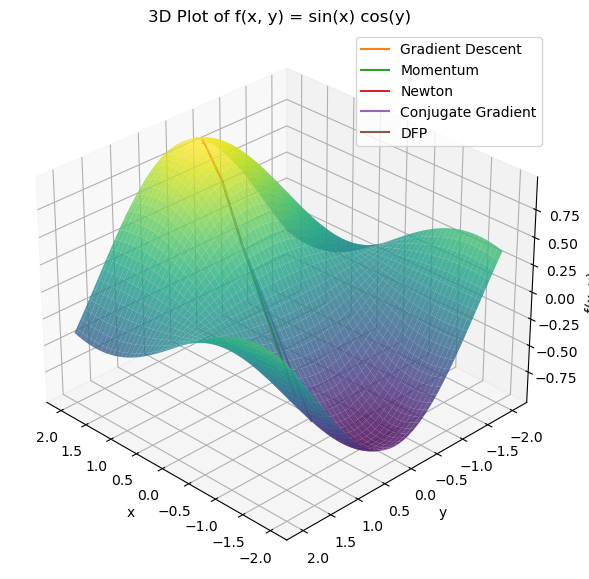

In [3]:
# Visualization for paths
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Generate data for the function
x_vals = np.linspace(-2, 2, 100)
y_vals = np.linspace(-2, 2, 100)
x_mesh, y_mesh = np.meshgrid(x_vals, y_vals)
z_mesh = np.sin(x_mesh) * np.cos(y_mesh)

# Plot the surface
ax.plot_surface(x_mesh, y_mesh, z_mesh, cmap='viridis', alpha=0.8)
ax.set_title('3D Plot of f(x, y) = sin(x) cos(y)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')

# Overlay paths
for path, label in zip([path_gd, path_momentum, path_newton, path_cg, path_dfp],
                       ["Gradient Descent", "Momentum", "Newton", "Conjugate Gradient", "DFP"]):
    path = np.array(path)
    ax.plot(path[:, 0], path[:, 1], [f.evalf(subs={x: p[0], y: p[1]}) for p in path], label=label)

ax.view_init(elev=30, azim=135)  # Adjust these values to get the desired view
ax.legend()
plt.show()

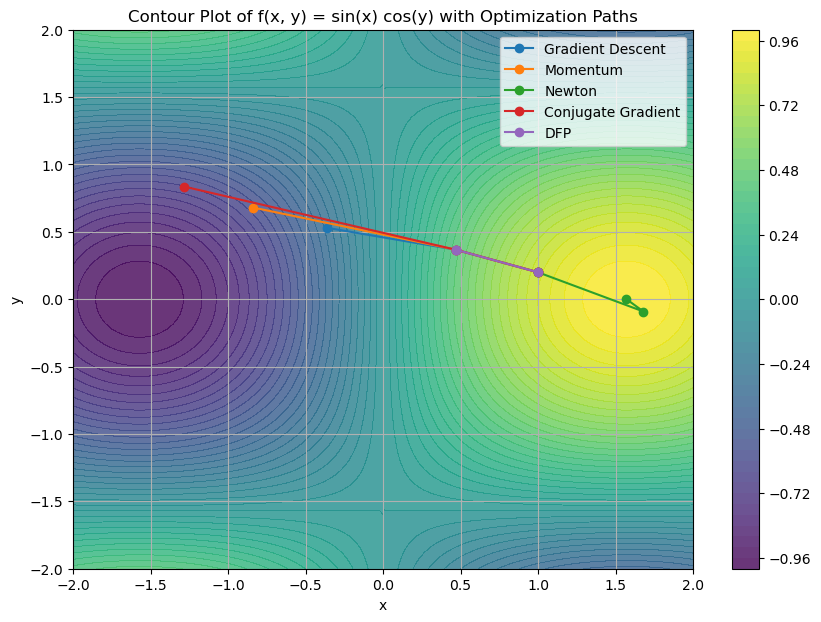

In [4]:
# 2D Contour Plot of the function with optimization paths

# Generate data for the function
x_vals = np.linspace(-2, 2, 100)
y_vals = np.linspace(-2, 2, 100)
x_mesh, y_mesh = np.meshgrid(x_vals, y_vals)
z_mesh = np.sin(x_mesh) * np.cos(y_mesh)

# Plot the contour
plt.figure(figsize=(10, 7))
contour = plt.contourf(x_mesh, y_mesh, z_mesh, levels=50, cmap='viridis', alpha=0.8)
plt.colorbar(contour)
plt.title('Contour Plot of f(x, y) = sin(x) cos(y) with Optimization Paths')
plt.xlabel('x')
plt.ylabel('y')

# Overlay optimization paths
for path, label in zip([path_gd, path_momentum, path_newton, path_cg, path_dfp],
                       ["Gradient Descent", "Momentum", "Newton", "Conjugate Gradient", "DFP"]):
    path = np.array(path)
    plt.plot(path[:, 0], path[:, 1], marker='o', label=label)  # Draw path as points and lines

plt.legend()
plt.grid(True)
plt.show()
